In [1]:
import numpy as np
import matplotlib.pyplot as plt

from itertools import product
from tqdm import tqdm, trange

from src.wishart import Wishart

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from abc import ABC, abstractmethod
from scipy.stats import entropy, mode

In [2]:
plt.style.use("default")

## Predictive Clustering

In [3]:
with open("lorenz.txt", "r") as f:
    xs = [float(x.rstrip("\n")) for x in f.readlines()]
    xs = np.array(xs)
x_train, x_test = xs[13000:23000], xs[23000:23600]

In [31]:
class PredictionMethod(ABC):
    @abstractmethod
    def select_prediction(self, prediction_set, distances):
        raise NotImplementedError()

    def __call__(self, prediction_set, distances):
        if len(prediction_set) == 0:
            return np.nan
        return self.select_prediction(prediction_set, distances)


class ModePredictionMethod(PredictionMethod):
    def __init__(self, weighted=False):
        self.weighted = weighted

    def select_prediction(self, prediction_set, distances):
        if self.weighted:
            weights = distances / np.sum(distances)
            return mode(weights*prediction_set, keepdims=False)
        return mode(prediction_set, keepdims=False).mode


class MeanPredictionMethod(PredictionMethod):
    def __init__(self, weighted=False):
        self.weighted = weighted

    def select_prediction(self, prediction_set, distances):
        if self.weighted:
            weights = distances / np.sum(distances)
            return np.mean(prediction_set)
        return np.mean(prediction_set*weights)


class DBSCANPredictionMethod(PredictionMethod):
    def __init__(self, eps=0.01, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def select_prediction(self, prediction_set, distances):
        dbs = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        dbs.fit(prediction_set.reshape(-1, 1))

        cluster_labels, cluster_sizes = np.unique(dbs.labels_[dbs.labels_ > -1], return_counts=True)

        if cluster_labels.size == 1:
            prediction = prediction_set[dbs.labels_ == cluster_labels[cluster_sizes.argmax()]].mean()
            return prediction

        max_cluster1, max_cluster2 = np.sort(cluster_sizes)[-2:]
        if max_cluster2 / max_cluster1 < 3:
            return np.nan

        if cluster_labels.size > 0:
            prediction = prediction_set[dbs.labels_ == cluster_labels[cluster_sizes.argmax()]].mean()
            return prediction
        return np.nan


class HistogramPredictionMethod(PredictionMethod):
    def __init__(self, b=5, k=2.0):
        self.b = b
        self.k = k

    def select_prediction(self, prediction_set, distances):
        hist, bin_edges = np.histogram(prediction_set, bins=self.b)
        largest_bin_index = np.argmax(hist)
        largest_bin_count = hist[largest_bin_index]
        total_points = len(prediction_set)

        if (largest_bin_count / total_points) > (self.k/self.b):
            bin_start, bin_end = bin_edges[largest_bin_index], bin_edges[largest_bin_index + 1]
            points_in_largest_bin = prediction_set[(prediction_set >= bin_start) & (prediction_set < bin_end)]
            return np.mean(points_in_largest_bin)
        return np.nan


class DivergencePredictionMethod(HistogramPredictionMethod):
    def select_prediction(self, prediction_set, distances):
        hist, bin_edges = np.histogram(prediction_set, bins=self.b, density=True)
        largest_bin_index = np.argmax(hist)
        uniform_distribution = np.ones(self.b) / self.b
        kl_divergence = entropy(hist, uniform_distribution)

        if kl_divergence > self.k/self.b:
            bin_start, bin_end = bin_edges[largest_bin_index], bin_edges[largest_bin_index + 1]
            points_in_largest_bin = prediction_set[(prediction_set >= bin_start) & (prediction_set < bin_end)]
            return np.mean(points_in_largest_bin)
        return np.nan

In [5]:
def f_dist(x, y):
    return np.linalg.norm(x-y, axis=1)


class ManyStepsAheadPredictor:
    def __init__(self, method: PredictionMethod, pattern_l=4, pattern_k=10, use_clustering=False, distance_funciton=None):
        self.get_prediction = method
        self.use_clustering = use_clustering
        self.distance_funciton = distance_funciton if distance_funciton is not None else f_dist
        self.patterns = self.generate_patterns(pattern_k, pattern_l)

    @staticmethod
    def generate_patterns(K, L):
        patterns = np.array(list(product(range(1, K+1), repeat=L-1)))
        return patterns

    @staticmethod
    def get_samples(x, pattern):
        T = len(x)
        inds = np.array([0, *np.cumsum(pattern)])

        samples = []
        for i in range(T-inds[-1]):
            sample = x[inds+i]
            # do not get samples for patterns in which a non-predictable value is contained
            if not np.isnan(sample).any():
                samples.append(sample)

        return np.array(samples)

    def _get_motives(self, x):
        return [self.get_samples(x, pattern) for pattern in self.patterns]

    def _get_motives_wishart(self, x):
        motives = []
        for pattern in self.patterns:
            samples = self.get_samples(x, pattern)

            lorenz_WC = Wishart(11, 0.2)
            _ = lorenz_WC.fit(samples)

            cluster_centers = []
            # zero cluster is noise
            for l in range(len(lorenz_WC.clusters_to_objects)):
                cluster_l = samples[lorenz_WC.clusters_to_objects[l]]
                if l == 0 or len(cluster_l) == 0:
                    continue
                cluster_centers.append(list(np.mean(cluster_l, axis=0)))
            motives.append(np.array(cluster_centers))
        return motives

    def get_prediction_set(self, x, motives, eps=0.005):
        set_predictions = []
        distances = []

        for i in range(len(self.patterns)):
            pattern = -np.cumsum(self.patterns[i][::-1])[::-1]
            new_motive = x[pattern]

            distances_i = self.distance_funciton(new_motive, motives[i][:, :-1])
            good_inds = distances_i < eps

            distances.extend(distances_i[good_inds])
            set_predictions.extend(motives[i][:,-1][good_inds])
        return np.array(set_predictions), np.array(distances)

    def predict_one_step(self, x):
        if self.use_clustering:
            motives = self._get_motives_wishart(x)
        else:
            motives = self._get_motives(x)
        prediction_set, distances = self.get_prediction_set(x, motives)
        return self.get_prediction(prediction_set, distances)

    def predict_many_steps(self, x, steps=10):
        predictions = []
        for _ in trange(steps):
            prediction = self.predict_one_step(x)
            predictions.append(prediction)
            x = np.append(x, prediction)
        return np.array(predictions)

In [6]:
method = DBSCANPredictionMethod()
predictor = ManyStepsAheadPredictor(method, pattern_l=4, pattern_k=5, use_clustering=False)
x_pred = predictor.predict_many_steps(x_train, steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [12:53<00:00, 15.47s/it]


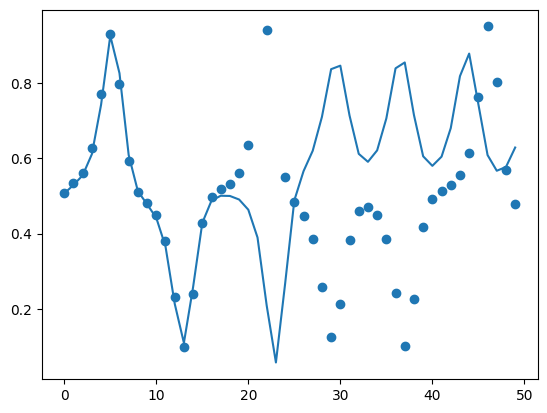

In [7]:
plt.scatter(np.arange(50), x_pred)
plt.plot(np.arange(50), x_test[:50])

In [8]:
nonan_x_pred = ~np.isnan(x_pred)
print(mean_squared_error(x_test[:50][nonan_x_pred], x_pred[nonan_x_pred]))
print(1 - nonan_x_pred.mean())

0.07711754025429593
0.040000000000000036


In [9]:
method = HistogramPredictionMethod(b=10, k=4)
predictor = ManyStepsAheadPredictor(method, pattern_l=4, pattern_k=5, use_clustering=False)
x_pred = predictor.predict_many_steps(x_train, steps=50)

100%|██████████| 50/50 [06:54<00:00,  8.30s/it]


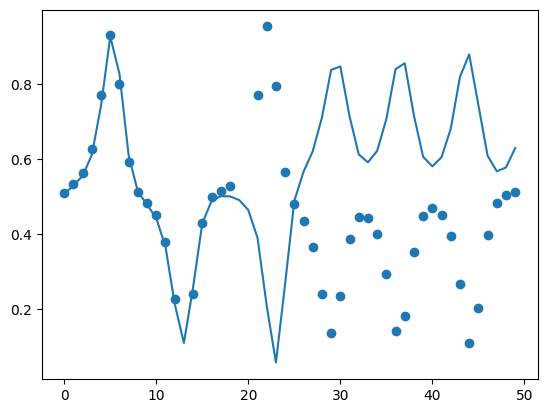

In [10]:
plt.scatter(np.arange(50), x_pred)
plt.plot(np.arange(50), x_test[:50])

In [12]:
nonan_x_pred = ~np.isnan(x_pred)
print(mean_squared_error(x_test[:50][nonan_x_pred], x_pred[nonan_x_pred]))
print(1 - nonan_x_pred.mean())

0.11436323339773229
0.06000000000000005


In [13]:
method = MeanPredictionMethod(weighted=True)
predictor = ManyStepsAheadPredictor(method, pattern_l=4, pattern_k=5, use_clustering=False)
x_pred = predictor.predict_many_steps(x_train, steps=50)

100%|██████████| 50/50 [06:40<00:00,  8.00s/it]


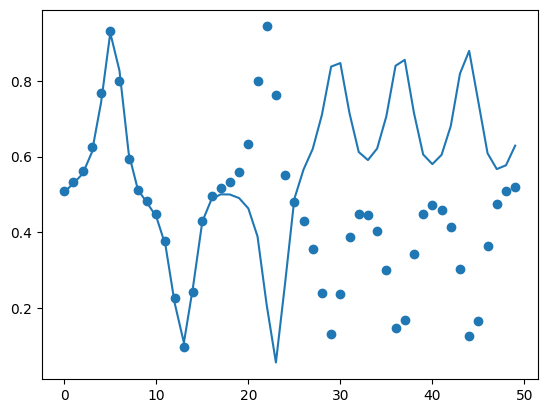

In [14]:
plt.scatter(np.arange(50), x_pred)
plt.plot(np.arange(50), x_test[:50])

In [15]:
nonan_x_pred = ~np.isnan(x_pred)
print(mean_squared_error(x_test[:50][nonan_x_pred], x_pred[nonan_x_pred]))
print(1 - nonan_x_pred.mean())

0.10685844400912256
0.0
